# Plaza italia isochrones

This notebook creates and saves isochrones on different input networks (variable 'project')

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Notebook config

In [2]:
all_isochrones = gpd.GeoDataFrame()

In [13]:
gral_dir = '../../../data/external/santiago/'
projected_crs = 'EPSG:32719'
filtering_column = 'pje_ep'
filtering_value = 0.5

# projects:
    #'redvial2019_buffer_3750m_c_utilidad_2' [complete network]
    #'red_buena_calidad',
    #'red_buena_calidad_pza_italia'
project_name = 'red_buena_calidad_pza_italia'

qgis_edges_dir = gral_dir+f'calidad_ep/{project_name}/{project_name}_single_parts.gpkg'
qgis_nodes_dir = gral_dir +f'calidad_ep/{project_name}/{project_name}_nodes.shp'

## Load data

In [14]:
################################## FUNCTION NOT WORKING, TEMPORAL QGIS FIX
# Filtered network - Load edges
edges_file = gpd.read_file(qgis_edges_dir)
edges_file = edges_file.set_crs(projected_crs)
# Filtered network - Load nodes
nodes_file = gpd.read_file(qgis_nodes_dir)
nodes_file = nodes_file.set_crs(projected_crs)
# Filtered network - Create navigable network
nodes, edges = aup.create_network(nodes_file, edges_file, projected_crs)
nodes = nodes.drop_duplicates(subset=['osmid'])
# Filtered network - Filter navigable network
edges_filt = edges.loc[edges[filtering_column] >= filtering_value]
# Filtered network - Filter nodes from edges
nodes_id = list(edges_filt.v.unique())
u = list(edges_filt.u.unique())
nodes_id.extend(u)
myset = set(nodes_id)
osmids_lst = list(myset)
nodes = nodes.loc[nodes.osmid.isin(osmids_lst)]
# Filtered network - Prepare nodes
nodes_gdf = nodes.copy()
nodes_gdf.set_index('osmid',inplace=True)
nodes_gdf['x'] = nodes_gdf['geometry'].x
nodes_gdf['y'] = nodes_gdf['geometry'].y
# Filtered network -  Prepare edges
edges_gdf = edges_filt.copy()
edges_gdf.set_index(['u','v','key'],inplace=True)
# Filtered network - Create G and rename nodes and edges
nodes = nodes_gdf.copy()
edges = edges_gdf.copy()
################################## FUNCTION NOT WORKING, TEMPORAL QGIS FIX

# Calculate time assuming a pedestrian speed of 4km/hr
###################################################################################### FROM ANALYSIS/POIS_TIME() FUNCTION
prox_measure = 'length'
# 2.1 --------------- FORMAT NETWORK DATA 
# Fill NANs in length with calculated length (prevents crash)
no_length = len(edges.loc[edges['length'].isna()])
edges = edges.to_crs(projected_crs)
edges['length'].fillna(edges.length,inplace=True)
edges = edges.to_crs("EPSG:4326")
print(f"Calculated length for {no_length} edges that had no length data.")

# If prox_measure = 'length', calculates time_min assuming walking speed = 4.5km/hr
if prox_measure == 'length':
    edges['time_min'] = (edges['length']*60)/4500
else:
    # NaNs in time_min? --> Assume walking speed = 4km/hr
    no_time = len(edges.loc[edges['time_min'].isna()])
    edges['time_min'].fillna((edges['length']*60)/4000,inplace=True)
    print(f"Calculated time for {no_time} edges that had no time data.")

edges = edges.to_crs("EPSG:4326")
######################################################################################

G = ox.graph_from_gdfs(nodes, edges)

Calculated length for 0 edges that had no length data.


In [15]:
# Show
print(nodes.shape)
nodes.head(1)

(14673, 12)


,fid,Nom_Rut,pje_ep,vertex_pos,vertex_ind,vertex_par,vertex_p_1,distance,angle,geometry,x,y
osmid,,,,,,,,,,,,
3509156302582,1.0,Costanera Sur,0.549756,0,0,0,0,0.0,191.098679,POINT (-70.60322 -33.40575),-70.603217,-33.405746


In [16]:
# Show
print(edges.shape)
edges.head(1)

(16289, 5)


,,,Nom_Rut,pje_ep,geometry,length,time_min
u,v,key,,,,,
3509156302582,3509786302390,0,Costanera Sur,0.549756,"LINESTRING (-70.60322 -33.40575, -70.60328 -33...",229.719497,3.062927


<Axes: >

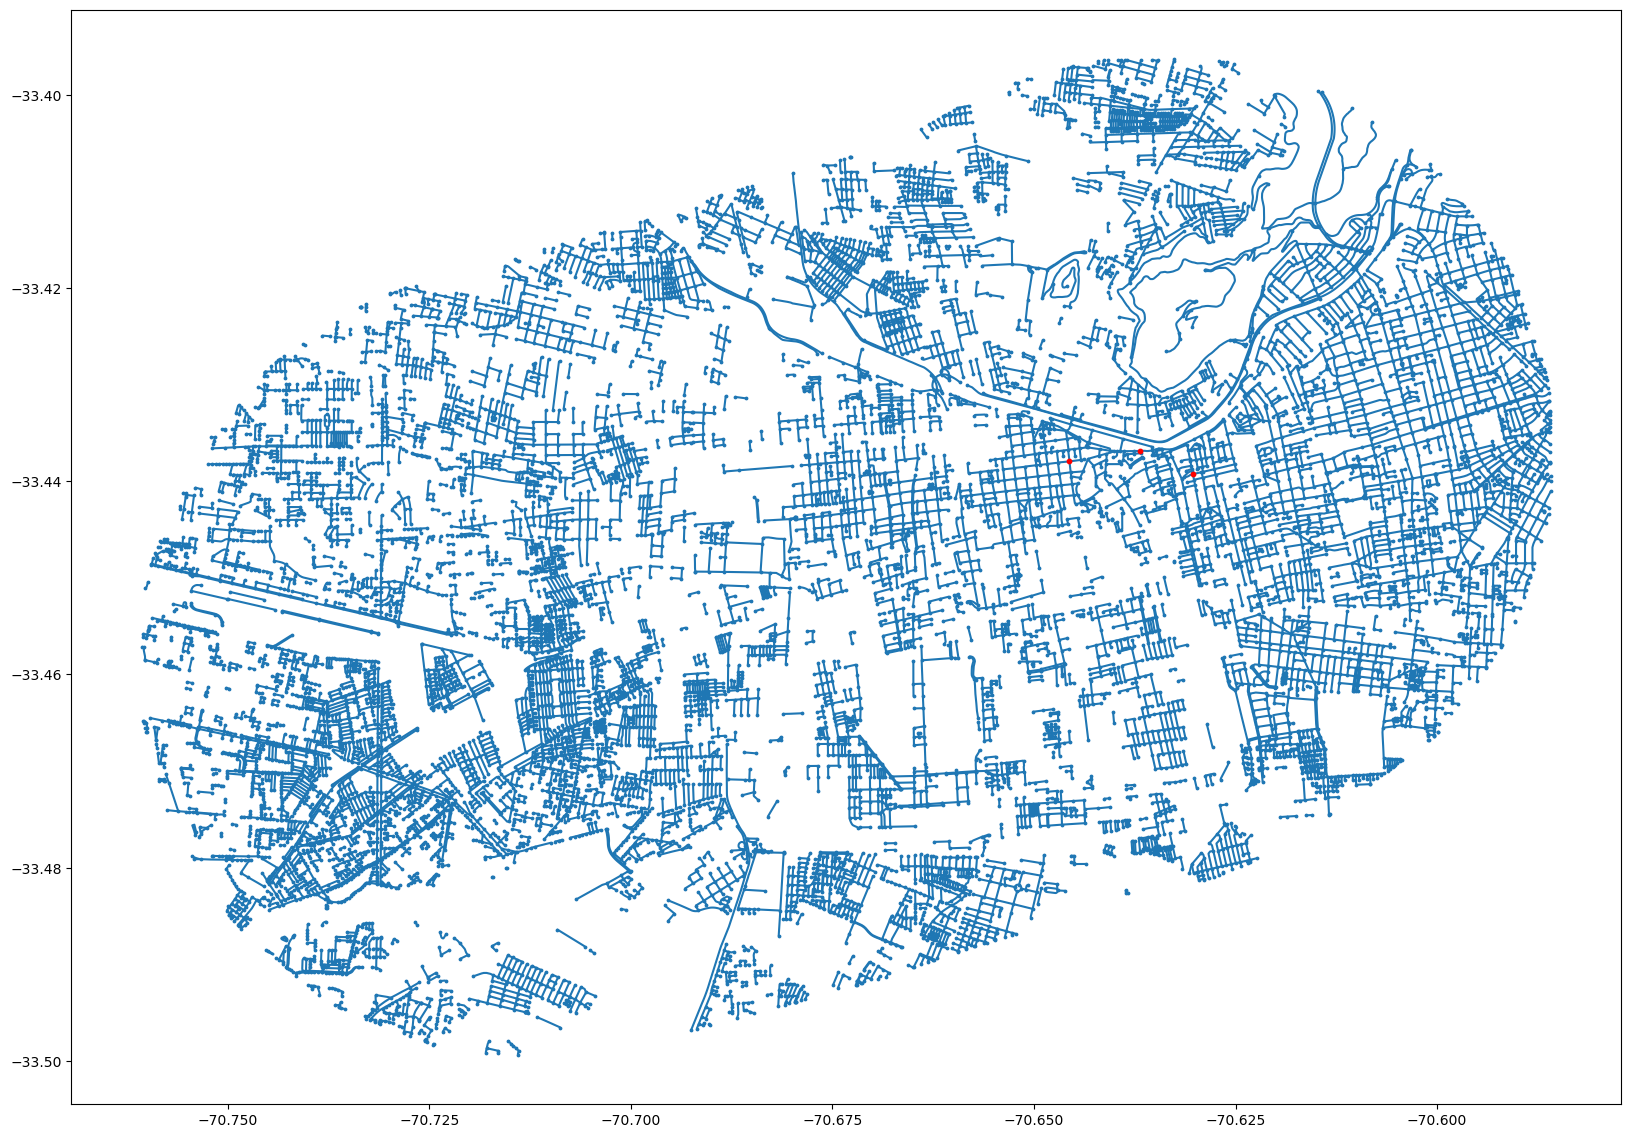

In [17]:
# Punto 1:
#Nom_Rut = Miraflores
#pje_ep = 0,66686750808651
point_1 = nodes.loc[(nodes.Nom_Rut == 'Miraflores') & (nodes.pje_ep == 0.66686750808651)]
point_1_osmid = point_1.reset_index().osmid.unique()[0]

# Punto 2:
#Nom_Rut = Av.Seminario
#pje_ep = 0,793683008815881
point_2 = nodes.loc[(nodes.Nom_Rut == 'Av.Seminario') & (nodes.pje_ep == 0.793683008815881)]
point_2_osmid = point_2.reset_index().osmid.unique()[0]

# Punto 3:
Nom_Rut = 'Merced'
pje_ep = 0,995782330183294
point_3 = nodes.loc[(nodes.Nom_Rut == 'Merced') & (nodes.pje_ep == 0.995782330183294)]
point_3_osmid = point_3.reset_index().osmid.unique()[0]

fig,ax = plt.subplots(figsize=(20,20))
point_1.plot(ax=ax,zorder=1,color='red',markersize=10)
point_2.plot(ax=ax,zorder=1,color='red',markersize=10)
point_3.plot(ax=ax,zorder=1,color='red',markersize=10)
edges.plot(ax=ax,zorder=0)
nodes.plot(ax=ax,zorder=0,markersize=3)

In [18]:
# Create isochrones
H = G.to_undirected()
nodes_list = [point_1_osmid,point_2_osmid,point_3_osmid]
isochrones_gdf = gpd.GeoDataFrame()
i = 0

for center_node in nodes_list:
    # Calculate isochrone
    sub_G, geometry = aup.calculate_isochrone(H, center_node, trip_time= 15, dist_column='time_min', subgraph=True)
    # Register in GeoDataFrame
    isochrones_gdf.loc[i,'project'] = project_name
    isochrones_gdf.loc[i,'point_id'] = center_node
    isochrones_gdf.loc[i,'geometry'] = geometry
    # Next
    i = i+1

# Show
print(isochrones_gdf.shape)
isochrones_gdf.head(3)

(3, 3)


,project,point_id,geometry
0,red_buena_calidad_pza_italia,3.470306e+12,"POLYGON ((-70.65006 -33.44386, -70.65102 -33.4..."
1,red_buena_calidad_pza_italia,3.484556e+12,"POLYGON ((-70.63030 -33.44803, -70.63285 -33.4..."
2,red_buena_calidad_pza_italia,3.478446e+12,"POLYGON ((-70.63180 -33.44409, -70.64529 -33.4..."


<Axes: >

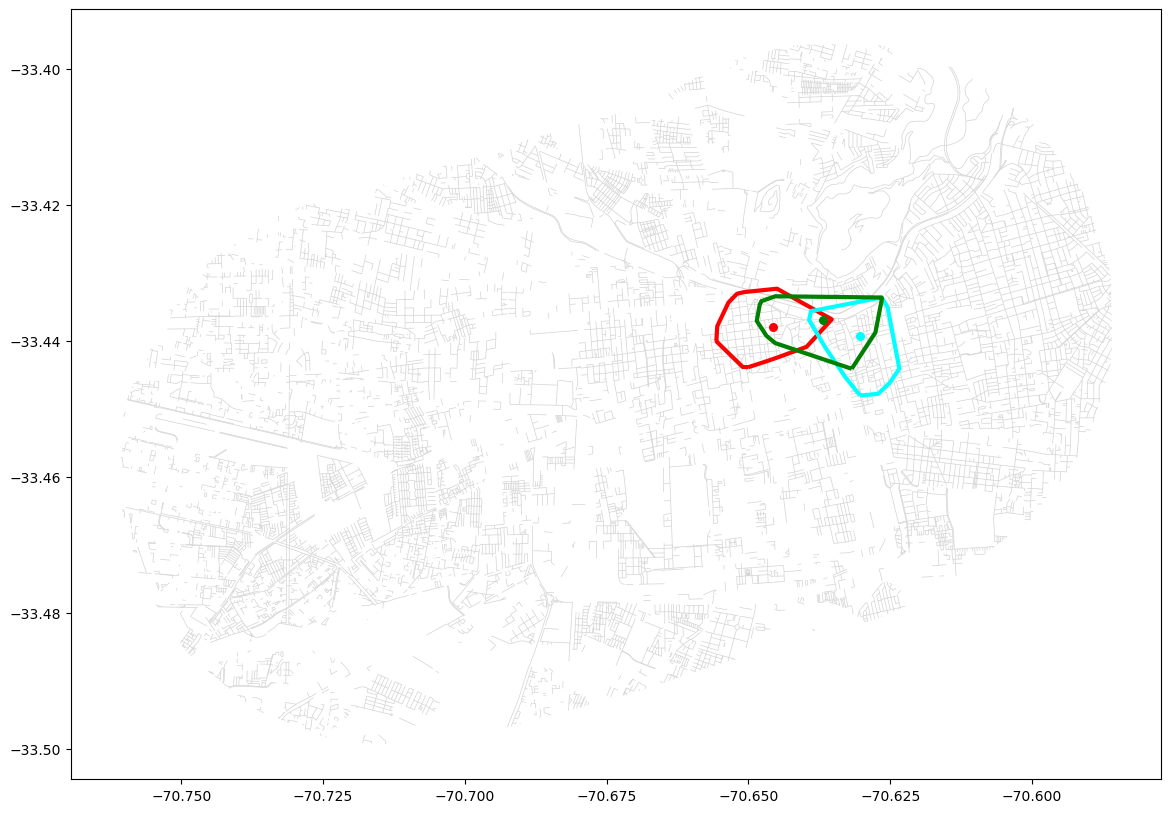

In [19]:
# Show plot
fig,ax = plt.subplots(figsize=(20,10))
nodes_reset = nodes.reset_index()

c = 0
colors = ['red','cyan','green']

for point in isochrones_gdf.point_id.unique():
    nodes_reset.loc[nodes_reset.osmid == point].plot(ax=ax,zorder=2,color=colors[c],markersize=30)
    isochrones_gdf.loc[isochrones_gdf.point_id == point].plot(ax=ax,zorder=1,facecolor='None',edgecolor=colors[c],linewidth=3)
    c = c+1

edges.plot(ax=ax,zorder=0,linewidth=0.5,edgecolor='lightgray')

In [20]:
all_isochrones = pd.concat([all_isochrones,isochrones_gdf])
all_isochrones

,project,point_id,geometry
0,red_buena_calidad,3.470306e+12,"POLYGON ((-70.65006 -33.44386, -70.65102 -33.4..."
1,red_buena_calidad,3.484556e+12,"POLYGON ((-70.63030 -33.44803, -70.63285 -33.4..."
2,red_buena_calidad,3.478446e+12,"POLYGON ((-70.63887 -33.44183, -70.64529 -33.4..."
0,red_buena_calidad_pza_italia,3.470306e+12,"POLYGON ((-70.65006 -33.44386, -70.65102 -33.4..."
1,red_buena_calidad_pza_italia,3.484556e+12,"POLYGON ((-70.63030 -33.44803, -70.63285 -33.4..."
2,red_buena_calidad_pza_italia,3.478446e+12,"POLYGON ((-70.63180 -33.44409, -70.64529 -33.4..."


<Axes: >

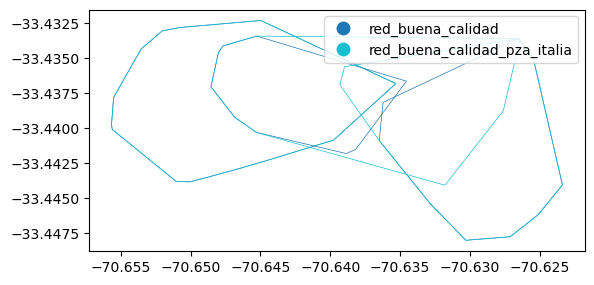

In [21]:
fig,ax = plt.subplots(1,1)
all_isochrones.plot('project',ax=ax,facecolor='None',linewidth=.5,legend=True)